[*********************100%***********************]  1 of 1 completed
45/45 [==============================] - 2s 20ms/step
RMSE: 0.20873957951419933


<ipython-input-40-1c9ab550378d>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


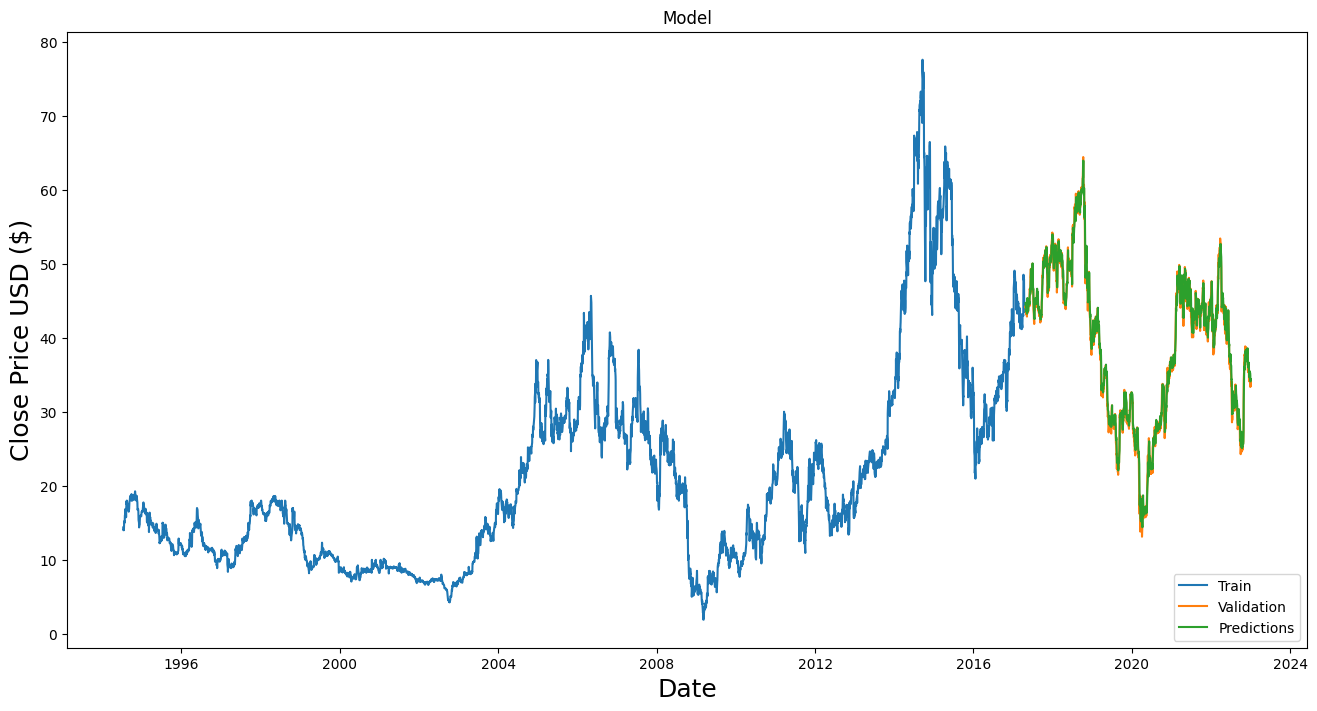

1/1 [==============================] - 0s 29ms/step
Predicted Close Price for 2023-04-29: 34.10


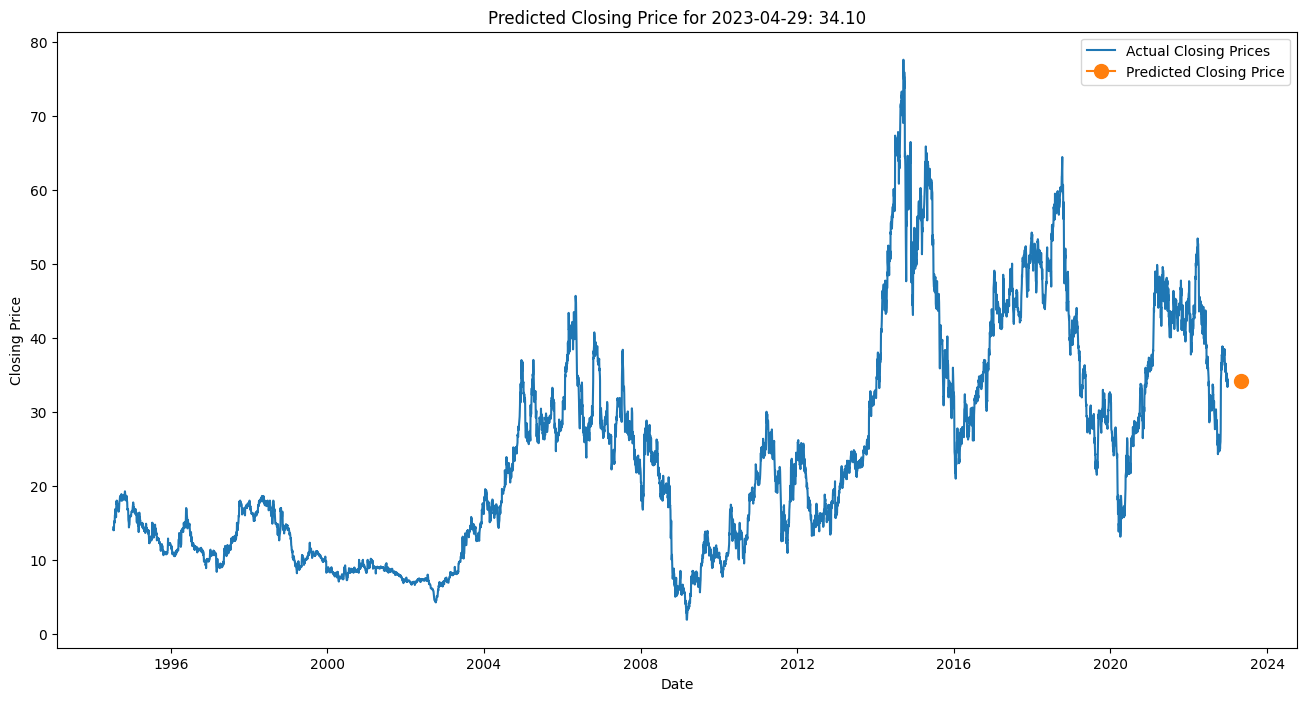

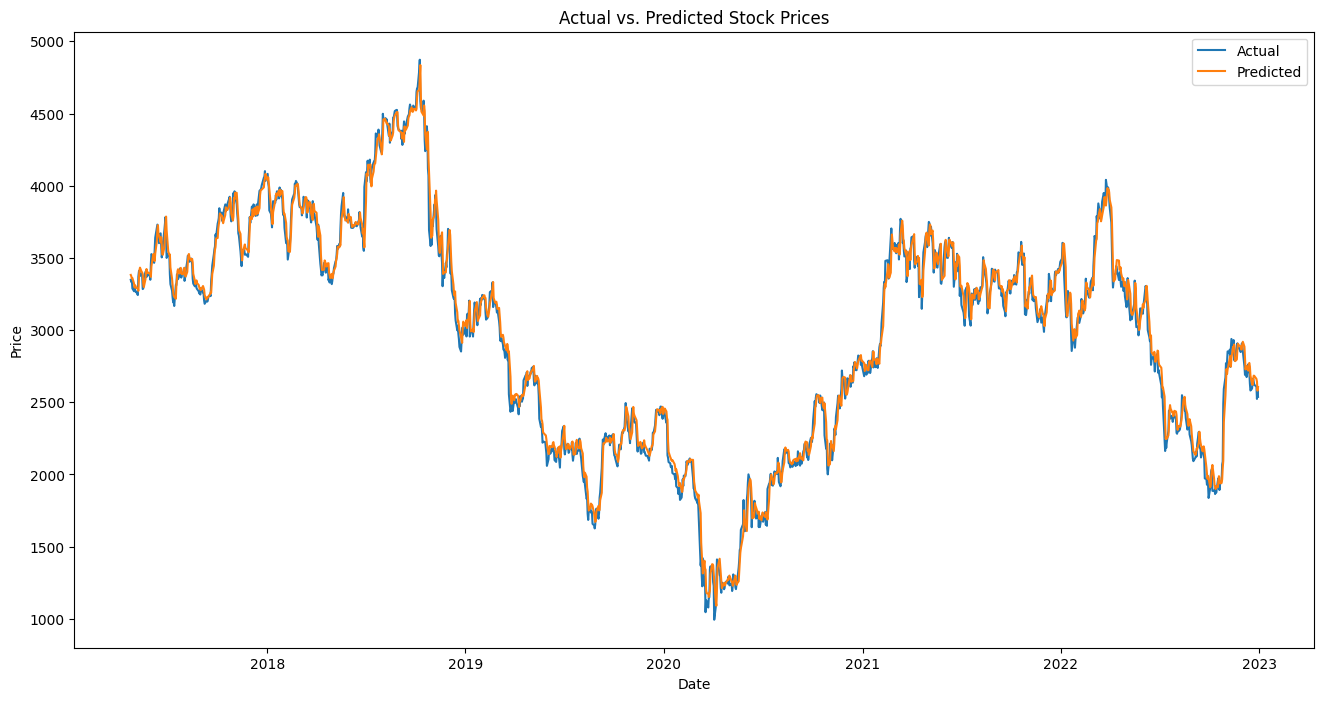

In [40]:
# Load the required libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Define the stock symbol and timeframe for the data
symbol = 'GBX'
start_date = '1994-06-14'
end_date = '2023-01-01'

# Retrieve the stock data from Yahoo Finance
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Create a new dataframe with only the 'Close' column
data = stock_data.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .8))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training dataset
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train datasets
x_train = []
y_train = []

lookback = 60
for i in range(lookback, len(train_data)):
    x_train.append(train_data[i-lookback:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create the testing dataset
test_data = scaled_data[training_data_len - lookback:, :]

# Split the data into x_test and y_test datasets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(lookback, len(test_data)):
    x_test.append(test_data[i-lookback:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate the model's performance
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print(f'RMSE: {rmse}')

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

# Make a prediction for the next day's closing price
last_date = stock_data.index[-1]
next_date = last_date + pd.DateOffset(days=120)
last_price = data['Close'].iloc[-lookback:].values.reshape(-1, 1)
last_price_scaled = scaler.transform(last_price)
next_day_prediction_scaled = model.predict(last_price_scaled.reshape(1, lookback, 1))[0][0]
next_day_prediction = scaler.inverse_transform([[next_day_prediction_scaled]])[0][0]
print(f'Predicted Close Price for {next_date.date()}: {next_day_prediction:.2f}')

# Plot the predicted and actual closing prices
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index, stock_data['Close'], label='Actual Closing Prices')
plt.plot(next_date, next_day_prediction, marker='o', markersize=10, label='Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title(f'Predicted Closing Price for {next_date.date()}: {next_day_prediction:.2f}')
plt.legend()
plt.show()

# Scale the actual and predicted prices back to their original values
actual_prices = scaler.inverse_transform(valid['Close'].values.reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1))

# Create a dataframe of the actual and predicted prices
price_df = pd.DataFrame({'Actual': actual_prices.flatten(), 'Predicted': predicted_prices.flatten()}, index=valid.index)

# Plot the actual and predicted prices
plt.figure(figsize=(16, 8))
plt.plot(price_df.index, price_df['Actual'], label='Actual')
plt.plot(price_df.index, price_df['Predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()


